In [ ]:
! pip -q install transformers datasets sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 16.1.0 which is incompatible.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 16.1.0 which is incompatible.


In [ ]:
from getpass import getpass
import os

os.environ['HF_TOKEN'] = getpass('Huggingface Access Token: ')

Huggingface Access Token: ··········


In [ ]:
import torch
import re
from PIL import Image
from transformers import DonutProcessor, VisionEncoderDecoderModel
import json

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
processor = DonutProcessor.from_pretrained("AdamCodd/donut-receipts-extract")
model = VisionEncoderDecoderModel.from_pretrained("AdamCodd/donut-receipts-extract")
model.to(device)

preprocessor_config.json:   0%|          | 0.00/440 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/7.88k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/1.30M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/4.01M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/908 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.04k [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/4.87k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/809M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/216 [00:00<?, ?B/s]

VisionEncoderDecoderModel(
  (encoder): DonutSwinModel(
    (embeddings): DonutSwinEmbeddings(
      (patch_embeddings): DonutSwinPatchEmbeddings(
        (projection): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      )
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DonutSwinEncoder(
      (layers): ModuleList(
        (0): DonutSwinStage(
          (blocks): ModuleList(
            (0-1): 2 x DonutSwinLayer(
              (layernorm_before): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
              (attention): DonutSwinAttention(
                (self): DonutSwinSelfAttention(
                  (query): Linear(in_features=128, out_features=128, bias=True)
                  (key): Linear(in_features=128, out_features=128, bias=True)
                  (value): Linear(in_features=128, out_features=128, bias=True)
                  (dropout): Dropout(p=0.0, inplace=False)
           

In [ ]:
def load_and_preprocess_image(image_path: str, processor):
    """
    Load an image and preprocess it for the model.
    """
    image = Image.open(image_path).convert("RGB")
    pixel_values = processor(image, return_tensors="pt").pixel_values
    return pixel_values

In [ ]:
def generate_text_from_image(model, image_path: str, processor, device):
    """
    Generate text from an image using the trained model.
    """
    # Load and preprocess the image
    pixel_values = load_and_preprocess_image(image_path, processor)
    pixel_values = pixel_values.to(device)

    # Generate output using model
    model.eval()
    with torch.no_grad():
        task_prompt = "<s_receipt>" # <s_cord-v2> for v1
        decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt").input_ids
        decoder_input_ids = decoder_input_ids.to(device)
        generated_outputs = model.generate(
            pixel_values,
            decoder_input_ids=decoder_input_ids,
            max_length=model.decoder.config.max_position_embeddings,
            pad_token_id=processor.tokenizer.pad_token_id,
            eos_token_id=processor.tokenizer.eos_token_id,
            early_stopping=True,
            bad_words_ids=[[processor.tokenizer.unk_token_id]],
            return_dict_in_generate=True
        )

    # Decode generated output
    decoded_text = processor.batch_decode(generated_outputs.sequences)[0]
    decoded_text = decoded_text.replace(processor.tokenizer.eos_token, "").replace(processor.tokenizer.pad_token, "")
    decoded_text = re.sub(r"<.*?>", "", decoded_text, count=1).strip()  # remove first task start token
    decoded_text = processor.token2json(decoded_text)
    return decoded_text

In [ ]:
# Example usage
image_path = "images/image2.jpg"  # Replace with your image path
extracted_text = generate_text_from_image(model, image_path, processor, device)
print("Extracted Text:", extracted_text)

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:563: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


Extracted Text: {'store_name': 'Centra', 'store_addr': 'JORDANS CENTRA CURRAGH GRANGE GREEN RD, NEWBRIDGE', 'phone': '', 'date': '14-02-2020', 'time': '19:16', 'subtotal': '', 'svc': '', 'tax': '', 'total': '€12.75', 'tips': '', 'discount': '', 'line_items': [{'item_key': '', 'item_name': 'PRINGLES C&O', 'item_value': '€2.25', 'item_quantity': '1'}, {'item_key': '', 'item_name': 'CARLING 8 PACK', 'item_value': '€10.50', 'item_quantity': '1'}]}


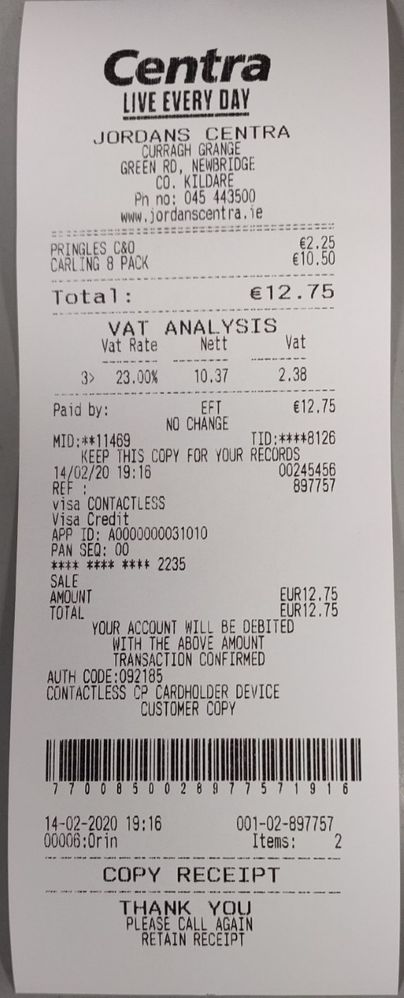

In [ ]:
image = Image.open(image_path).convert("RGB")
image

In [ ]:
def extract_receipt_info(data):
    # Extract required fields
    store_name = data.get('store_name')
    date = data.get('date')
    time = data.get('time')
    total = data.get('total')
    line_items = data.get('line_items')

    # Format date and time
    if date and time:
        date_time = f"{date} - {time}"
    elif date:
        date_time = date
    else:
        date_time = None

    # Construct result dictionary
    result = {
        "store_name": store_name,
        "date_time": date_time,
        "total": total,
        "line_items": line_items
    }

    return result

In [ ]:
receipt_data = json.dumps(extracted_text)
receipt_data = json.loads(receipt_data)

In [ ]:
extract_receipt_info(receipt_data)

{'store_name': 'Centra',
 'date_time': '14-02-2020 - 19:16',
 'total': '€12.75',
 'line_items': [{'item_key': '',
   'item_name': 'PRINGLES C&O',
   'item_value': '€2.25',
   'item_quantity': '1'},
  {'item_key': '',
   'item_name': 'CARLING 8 PACK',
   'item_value': '€10.50',
   'item_quantity': '1'}]}